In [3]:
import mdtraj as md
import pyemma as pm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Optional, Union, Tuple
from pathlib import Path
import pickle
import seaborn as sns
import os
from itertools import product
import string
import pickle
from datetime import timedelta

import matplotlib as mpl
from matplotlib import colors

# import MDAnalysis as mda
# from MDAnalysis.analysis.dihedrals import Dihedral, Ramachandran

In [4]:
summary_paths = ['../CLN/maximize_t2.h5', '../CLN/t2+gap.h5',
                 '../CLN/vampeq2.h5', '../CLN/vampeq2+vamp23gap.h5',
                 '../BBA/t2.h5', '../BBA/t2+gap.h5',
                 '../BBA/vampeq2.h5', '../BBA/vampeq2+vamp23gap.h5']
summary = {}

In [5]:
for summary_path in summary_paths:
    
    hps = pd.read_hdf(summary_path)
    hps = hps.loc[hps['state'] == 'COMPLETE', :].copy()
    # hps = hps[hps['state'] == 'COMPLETE']

    hps['is_initial'] = (hps.duration < timedelta(seconds=0.1))
    no_initial = sum(hps['is_initial'])
    
    hps.rename(columns=dict(number='hp_ix', 
                            params_centre='distances__centre', 
                            params_feature='feature__value', 
                            params_n_clusters='cluster__k', 
                            params_scheme='distances__scheme', 
                            params_steepness='distances__steepness', 
                            params_tica_dim='tica__dim', 
                            params_tica_lag='tica__lag', 
                            params_transform='distances__transform'), inplace=True)
    if 'values_0' in hps.columns:
        hps.rename(columns={'values_0':'gap', 'values_1':'target'}, inplace=True)
    else:
        hps.rename(columns={'value':'target'}, inplace=True)
    
    hps['incumbent'] = hps.apply(lambda x: max(hps['target'][:x['hp_ix']+1]), axis=1)
    # hps['incumbent'][:no_initial] = max(hps['incumbent'][:no_initial])
    hps.loc[hps.index[:no_initial], 'incumbent'] = hps.loc[hps.index[:no_initial], 'incumbent'].max()


    
    if 'CLN' in summary_path: 
        name = 'CLN_' + Path(summary_path).stem
    else:
        name = 'BBA_' + Path(summary_path).stem
    summary.update({name:hps})
    
    print(name, no_initial)

CLN_maximize_t2 131
CLN_t2+gap 55
CLN_vampeq2 131
CLN_vampeq2+vamp23gap 55
BBA_t2 136
BBA_t2+gap 136
BBA_vampeq2 136
BBA_vampeq2+vamp23gap 136


In [6]:
for k, data in summary.items():
    print(k)

CLN_maximize_t2
CLN_t2+gap
CLN_vampeq2
CLN_vampeq2+vamp23gap
BBA_t2
BBA_t2+gap
BBA_vampeq2
BBA_vampeq2+vamp23gap


In [21]:
def vamp_to_t2(v, tau): 
    x = np.sqrt(v-1)
    return -tau/np.log(x)/1000

def t2_to_vamp(t, tau): 
    return 1 + np.exp(-2*tau/(t*1000))
    

def plot_incumbent(ax, id_1, id_2, c_1d, c_1, c_2d, c_2):
    if 'CLN' in id_1: 
        vdelta = 0.0007
        tdelta = -0.001
        tau = 31
    else: 
        tau = 41
        vdelta = 0.0002
        tdelta = 2


    
    if 't2' in id_1:
        incumbent_1 = summary[id_1]['incumbent']/1000
        incumbent_2 = summary[id_2]['incumbent']/1000
        label_1 = r'$t_{2}$'
        label_2 = r'$t_{2}$, $t_{2}/t_{3}$'
    else:
        incumbent_1 = summary[id_1]['incumbent']
        incumbent_2 = summary[id_2]['incumbent']
        label_1 = r'V$_{eq}(2)$'
        label_2 = r'V$_{eq}(2)$, V$_{eq}(2)$/V$_{eq}(3)$'
    
    no_init_1 = sum(summary[id_1]['is_initial'])
    no_init_2 = sum(summary[id_2]['is_initial'])

    init_size = 2
    opt_size = 30
    ax.plot(summary[id_1]['hp_ix'][:no_init_1],
            incumbent_1[:no_init_1],
               # c=c_1d,
               c = c_1,
               lw=init_size,
               # marker='_',
               label=f"init. ({label_1})")
    ax.plot(summary[id_2]['hp_ix'][:no_init_2],
            incumbent_2[:no_init_2],
               # c=c_2d,
               c = c_2,
               lw=init_size,
               # marker='_',
               label=f"init. ({label_2})")
    
    ax.scatter(x=summary[id_1]['hp_ix'][no_init_1:],
               y=incumbent_1[no_init_1:],
               c=c_1,
               s=30,
               label=label_1,
               marker='s')
    
    xpos, ypos =  max(summary[id_1]['hp_ix'][no_init_1:]), max(incumbent_1[no_init_1:])
    if not 't2' in id_1:      
        t2 = vamp_to_t2(ypos, tau)
        delta = vdelta
    else: 
        t2 = ypos
        delta = tdelta
    ax.annotate(text=f"{t2:4.3f}"+r"$\mu s$",xy=(xpos, ypos - delta), horizontalalignment='right' )
    
    ax.scatter(x=summary[id_2]['hp_ix'][no_init_2:],
               y=incumbent_2[no_init_2:],
               c=c_2,
               s=30,
               label=label_2,
               marker='s')

    xpos, ypos =  max(summary[id_2]['hp_ix'][no_init_1:]), max(incumbent_2[no_init_1:])
    if not 't2' in id_1:      
        t2 = vamp_to_t2(ypos, tau)
        delta = vdelta
    else: 
        t2 = ypos
        delta = tdelta
        
    ax.annotate(text=f"{t2:4.3f}"+r"$\mu s$",xy=(xpos, ypos - delta), horizontalalignment='right' )
    
    ax.legend(loc='upper left', bbox_to_anchor=(-0.01, 1.01), 
              borderpad=0.4, labelspacing=0.2, 
             handlelength=1, handletextpad=0.4)
    return None

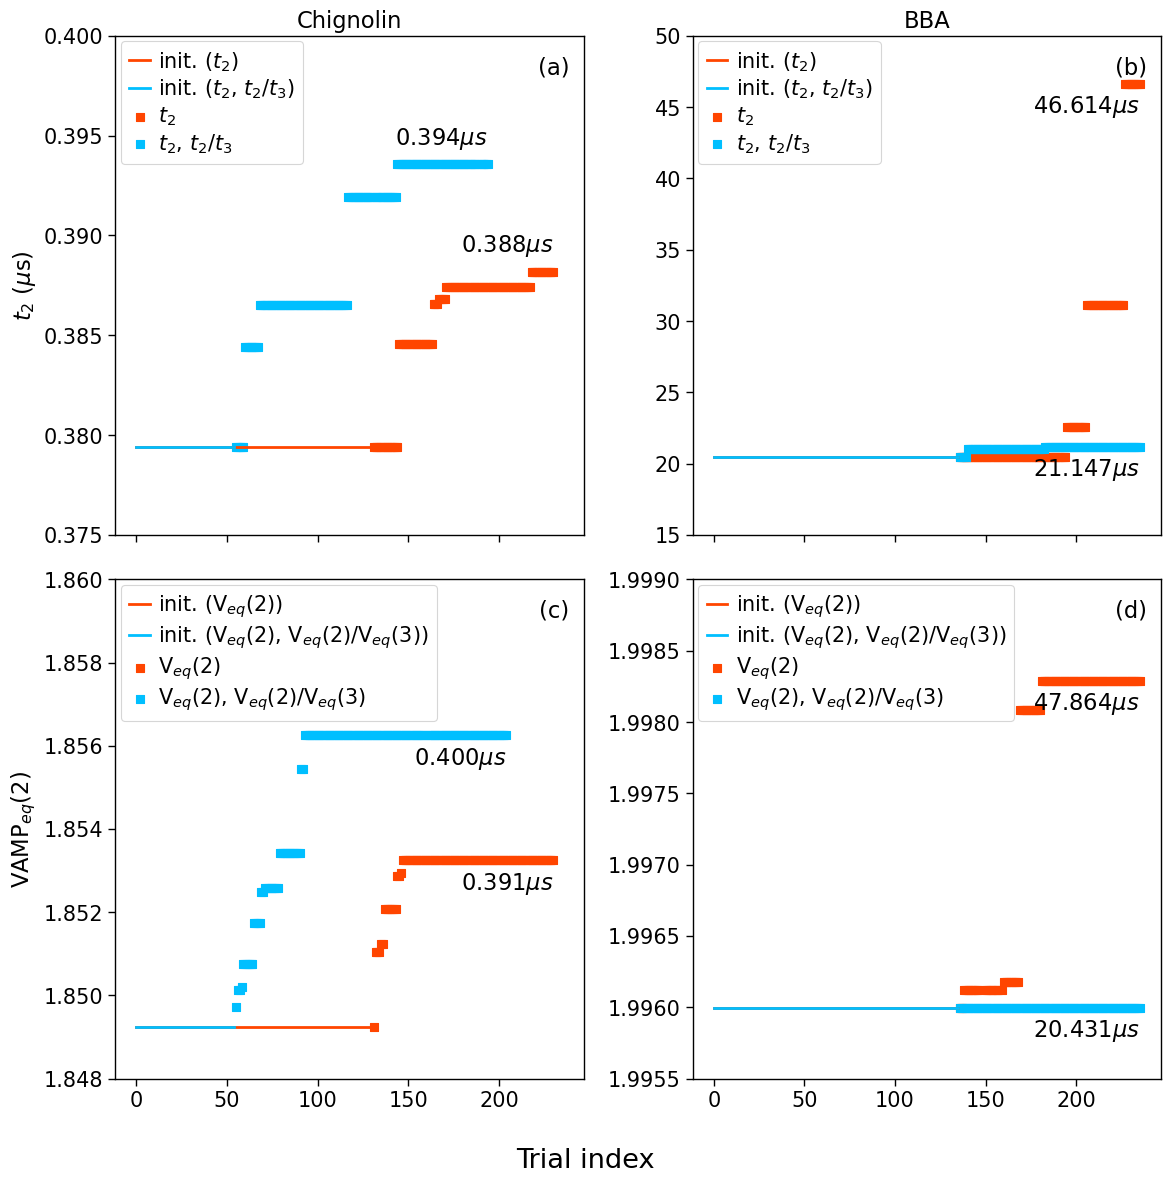

In [22]:
with sns.plotting_context('paper', font_scale=1.7):
    fig, axes = plt.subplots(2,2, figsize=(12,12), sharex=True)

    plot_incumbent(axes[0][0], 'CLN_maximize_t2', 'CLN_t2+gap', 'darkred', 'orangered', 'darkslategray', 'deepskyblue')
    plot_incumbent(axes[1][0], 'CLN_vampeq2', 'CLN_vampeq2+vamp23gap', 'darkred', 'orangered', 'darkslategray', 'deepskyblue')
    plot_incumbent(axes[0][1], 'BBA_t2', 'BBA_t2+gap', 'darkred', 'orangered', 'darkslategray', 'deepskyblue')
    plot_incumbent(axes[1][1], 'BBA_vampeq2', 'BBA_vampeq2+vamp23gap', 'darkred', 'orangered', 'darkslategray', 'deepskyblue')

    axes[0][0].set_title('Chignolin')
    axes[0][1].set_title('BBA')
    axes[0][0].set_ylabel(r'$t_{2}$ ($\mu$s)')
    axes[1][0].set_ylabel(r'VAMP$_{eq}(2)$')
    
    axes[0][0].set_ylim([0.375, 0.400])
    axes[0][1].set_ylim([15, 50])
    axes[1][0].set_ylim([1.848, 1.860])
    axes[1][1].set_ylim([1.9955, 1.999])

    fig.supxlabel('Trial index')
    
    for i, ax in enumerate(axes.flatten()):
        ax.tick_params(axis='both', bottom=True, top=False, left=True, right=False)
        ax.annotate(text=f'({chr(i+97)})', xy=(0.97, 0.96), xycoords='axes fraction', ha='right', va='top')

    
    plt.tight_layout()
    plt.savefig('optimisation_summary.pdf')
    plt.show()